### Problem 1

Get the heart disease data from [this site](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/coris.dat). Consider a Bayesian analysis of the logistic regression model (chapter 4.3.2 in [2]). 

$$P(Y=1 \left |  \right . X=x ) = \frac{e^{\beta_0 + \boldsymbol{\beta} x}}{1+e^{\beta_0 + \boldsymbol{\beta} x}}$$
$$ \boldsymbol{\beta} = (\beta_1, \beta_2, ... , \beta_k)$$

Use the flat prior $f(\beta_0,...,\beta_k) \propto 1$. Use the Gibbs-Metropolis algorithm (Chapter 24 in [4]) to draw sample of size $10,000$ from the posterior $f(\beta_0,\beta_1 \left |  \right . data)$. Plot histograms of the posteriors for the $\beta_j$'s. Get the posterior mean and a 95 percent posterior interval for each $\beta_j$.

Compare your analysis to a frequentist approach using maximum likelihood (Chapter 9.3 in [4]), you can use **PyMC3** module to perform sampling.

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import tensor as T
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('coris.dat', sep=',', index_col=0)

In [3]:
X = data.values[:, :-1]
y = data.values[:, -1]

In [4]:
X = np.hstack((np.ones((X.shape[0], 1)), X))

In [5]:
with pm.Model() as normal_model: 

    beta = pm.Flat('beta', shape=X.shape[1])

    prediction = T.nnet.sigmoid(T.dot(X, beta))
    likelihood = pm.Bernoulli('y', p=prediction, observed=y)

/Users/ilia/anaconda/lib/python2.7/site-packages/theano/tensor/basic.py:2124: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [6]:
with normal_model:
    start = pm.find_MAP() 
    step = pm.Metropolis(start=start) 
    trace = pm.sample(10000, step, start=start, progressbar=True)
    
beta_map = start['beta']
beta_samples = trace.get_values('beta')

Optimization terminated successfully.
         Current function value: 236.070016
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26


100%|██████████| 10000/10000 [00:01<00:00, 6558.55it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f440cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f44bd10>]], dtype=object)

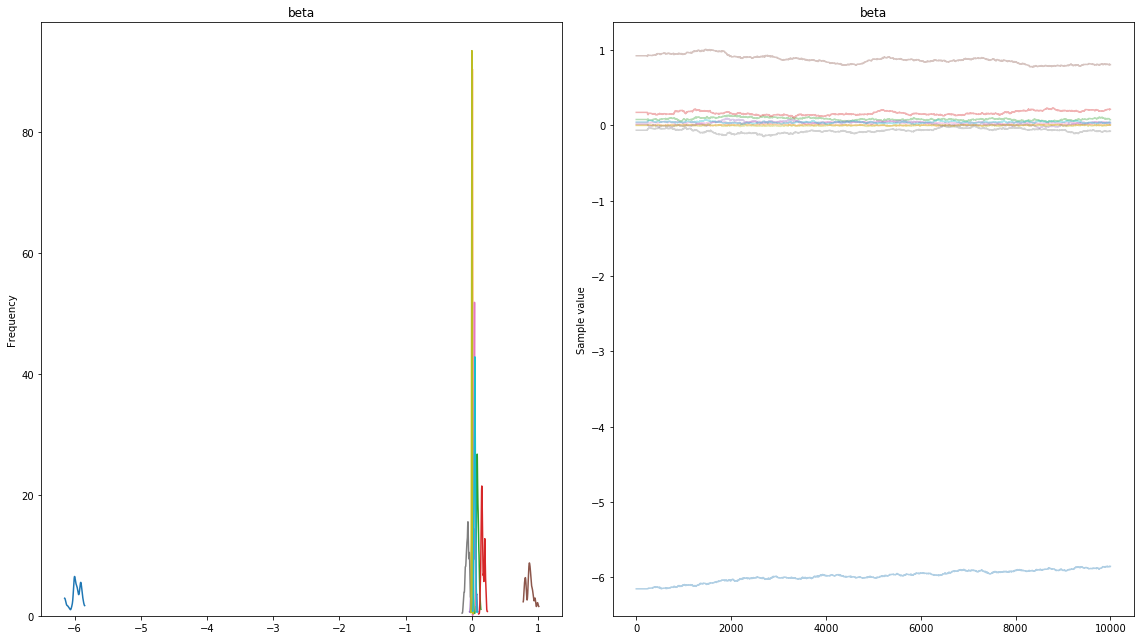

In [7]:
pm.traceplot(trace, figsize=(16, 9))

In [8]:
mean_beta = beta_samples.mean(axis=0)
left = np.percentile(beta_samples, 5, axis=0)
right = np.percentile(beta_samples, 95, axis=0)

for i in xrange(mean_beta.size):
    print 'beta[%d]: interval - [%.4f, %.4f], mean - %.4f, map - %.4f' % (i, left[i], right[i], mean_beta[i], beta_map[i])

beta[0]: interval - [-6.1398, -5.8753], mean - -5.9815, map - -6.1507
beta[1]: interval - [-0.0014, 0.0142], mean - 0.0065, map - 0.0065
beta[2]: interval - [0.0604, 0.1163], mean - 0.0854, map - 0.0794
beta[3]: interval - [0.1300, 0.2098], mean - 0.1652, map - 0.1739
beta[4]: interval - [-0.0124, 0.0699], mean - 0.0265, map - 0.0186
beta[5]: interval - [0.7912, 0.9844], mean - 0.8747, map - 0.9254
beta[6]: interval - [0.0244, 0.0517], mean - 0.0381, map - 0.0396
beta[7]: interval - [-0.1189, -0.0256], mean - -0.0689, map - -0.0629
beta[8]: interval - [-0.0079, 0.0075], mean - -0.0002, map - 0.0001
beta[9]: interval - [0.0265, 0.0603], mean - 0.0431, map - 0.0452


We see that MAP estimation lies in the interval and approximately equals to the mean.

### Problem 2

Illustrate the mean-field approximation and its use in variational Bayesian Inference (chapter 10 in [2] and [3]) using a linear regression model, on [Boston house prices dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

$$y_i = \mathbf{x_i} \boldsymbol{\beta} + \epsilon_i ,$$

$$\epsilon_i \sim \mathcal{N}(0, \sigma^2),  i=1...N , $$

with semi-conjugate priors,

$$\boldsymbol{\beta} \sim \mathcal{N}(\boldsymbol{\mu}_\beta, \mathbf{\Sigma_\beta})$$
$$\sigma^2 \sim InverseGamma(a, b)$$

Find an approximation of the posterior distribution $q(\boldsymbol{\beta}, \sigma^2)$ by replacing it with factorisation of simpler probability densities[1].


Write implementation of the variational search and visualize convergence of ELBO (Evidence Lower Bound)[5] defined as: $$\mathcal{L}(q) = \mathbb{E}_q \log p(\boldsymbol{y}, \boldsymbol{\beta}, \sigma^2) − \mathbb{E}_q\log (q^*(\boldsymbol{\beta})\cdot q^*(\sigma^2)).$$


Let us derive formulas for iterations of variational inference:

$$\log q(\sigma^2) = \mathrm{const} + \mathbb{E}_{q(\pmb{\beta})} \log p(\pmb y|X, \pmb\beta, \sigma^2)p(\pmb\beta)p(\sigma^2) = \mathrm{const} + \mathbb{E}_{q(\pmb{\beta})}\log p(\pmb y|X, \pmb\beta, \sigma^2) + \log p(\sigma^2) = \mathrm{const} - \frac{N\log\sigma^2}{2} - \frac{1}{2\sigma^2} \mathbb{E}_{q(\pmb{\beta})} (X\pmb\beta - \pmb y)^T(X\pmb\beta - \pmb y) -  (a + 1)\log\sigma^2 - \frac{b}{\sigma^2}$$
$$ \mathbb{E}_{q(\pmb{\beta})} (X\pmb\beta - \pmb y)^T(X\pmb\beta - \pmb y) = \mathbb{E}_{q(\pmb{\beta})} \pmb\beta^TX^TX\pmb\beta - 2y^TX\pmb\mu_n + \pmb y^T\pmb y = \mathrm{tr}(X^TX\Sigma_n) + (X\pmb\mu_n - \pmb y)^T(X\pmb\mu_n - \pmb y)$$

$$a_n = a + \frac{N}{2}$$
$$b_n = b + \frac{(X\pmb\mu_n - \pmb y)^T(X\pmb\mu_n - \pmb y)}{2} + \frac{\mathrm{tr}(X^TX\Sigma_n)}{2}$$

$$\log q(\pmb\beta)  = \mathrm{const} + \mathbb{E}_{q(\sigma^2)} \log p(\pmb y|X, \pmb\beta, \sigma^2)p(\pmb\beta)p(\sigma^2) = \mathrm{const} -\mathbb{E}_{q(\sigma^2)}\frac{1}{2\sigma^2} (X\pmb\beta - \pmb y)^T(X\pmb\beta - \pmb y) - \frac{(\pmb \beta - \pmb\mu)^T\Sigma^{-1}(\pmb \beta - \pmb\mu)}{2}$$

$$\frac{a_n}{b_n} (X\pmb\beta - \pmb y)^T(X\pmb\beta - \pmb y) + (\pmb \beta - \pmb\mu)^T\Sigma^{-1}(\pmb \beta - \pmb\mu) = \pmb\beta^T (\frac{a_n}{b_n}X^TX + \Sigma^{-1})\pmb\beta - 2\frac{a_n}{b_n}\pmb y^TX\pmb\beta - 2\pmb\mu^T\Sigma^{-1}\pmb\beta + \mathrm{const}$$
$$ \Sigma^{-1}_n = \frac{a_n}{b_n}X^TX + \Sigma^{-1}$$
$$\pmb\mu_n = \Sigma_n(\frac{a_n}{b_n}X^T\pmb y + \Sigma^{-1}\pmb\mu)$$

ELBO:

$\mathcal{L}(q) = \mathbb{E}_{q(\pmb\beta)q(\sigma^2)} \log p(\pmb y|X, \pmb\beta, \sigma^2) + \mathbb{E}_{q(\pmb\beta)}\log p(\pmb\beta) + \mathbb{E}_{q(\sigma^2)}p(\sigma^2) + \mathbb{H}q(\pmb\beta) + \mathbb{H}q(\sigma^2)$

In [9]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
from sklearn.linear_model.base import BaseEstimator
from scipy.special import digamma, gammaln

class VariationalLinearRegression(BaseEstimator):
    def __init__(self, max_iter=300, n_init=10, a=1, b=1, l=1, tol=1e-5, logging=False):
        self.a = a
        self.b = b
        self.l = l #diagonal covariance for prior with 1/sigma^2 = l
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.logging = logging

    def fit(self, X_, y):
        
        X = np.hstack((X_, np.ones((X_.shape[0], 1))))
        
        n_objects = X.shape[0]
        n_features = X.shape[1]
        
        G = X.T.dot(X) 
        y_ = X.T.dot(y)
        
        a = n_objects / 2. + self.a
        best_elbo = -np.inf
        
        for i in xrange(self.n_init):
            if self.logging:
                logs = {}
                logs['elbo'] = []
            mu = np.random.rand(n_features)
            S = np.zeros((n_features, n_features))
            np.fill_diagonal(S, np.random.rand(n_features))
            elbo_ = -np.inf
            converged = False
            i = 0
            while not converged > self.tol and i < self.max_iter:

                b = self.b + 0.5 * (np.sum(np.square(X.dot(mu) - y)) + 0.5 * np.sum(np.multiply(G, S)))
                S = np.linalg.inv(G * a / b + self.l)
                mu = S.dot(y_) * a / b   

                elbo = -n_objects * (np.log(2 * np.pi) + np.log(b) - digamma(a)) / 2
                elbo += (np.sum(np.square(X.dot(mu) - y)) + np.sum(np.multiply(G, S))) * a / b / 2
                elbo += -n_features * (np.log(2 * np.pi) - np.log(self.l)) / 2
                elbo += -self.l * (np.trace(S) + np.sum(np.square(mu))) / 2
                elbo += self.a * np.log(self.b) - gammaln(self.a)
                elbo += -(self.a + 1) * (np.log(b) - digamma(a))
                elbo += -self.b * a / b
                elbo += n_features * np.log(2 * np.pi * np.e / self.l) / 2
                elbo += a + np.log(b) + gammaln(a) - (a + 1) * digamma(a)
                
                i += 1
                if self.logging:
                    logs['elbo'].append(elbo)
                if elbo - elbo_ < self.tol:
                    converged = True
                elbo_, elbo = elbo, elbo_
                
            if elbo_ > best_elbo:
                best_elbo = elbo_
                self.beta = mu
                if self.logging:
                    self.logs = logs
                    
    def predict(self, X):
        return X.dot(self.beta[:-1]) + self.beta[-1]

In [11]:
model = VariationalLinearRegression(logging=True)

In [12]:
model.fit(X_train, y_train)
print 'RMSE:', np.sqrt(np.square(model.predict(X_test) - y_test).mean())

RMSE: 4.99697168308


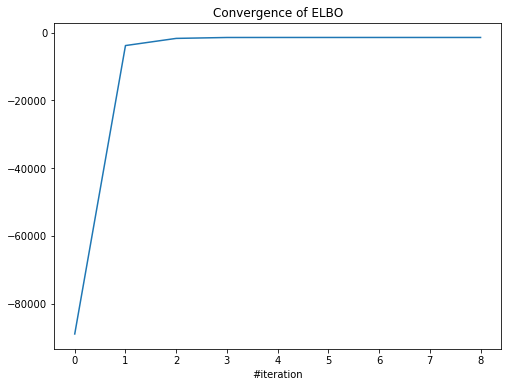

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(model.logs['elbo'])
plt.xlabel('#iteration')
plt.title('Convergence of ELBO')

# References

1. Ormerod, J. T. and M. P. Wand (2010). “Explaining variational approximations,” The American Statistician,
64(2), 140-153. [[pdf](http://ro.uow.edu.au/cgi/viewcontent.cgi?article=1026&context=cssmwp)]
2. Bishop, C. M. (2006). Pattern recognition. Machine Learning.
3. Ansari, A. (2014). Variational Bayesian Inference for Big Data Marketing Models (Doctoral dissertation, University of Washington). [[pdf](https://bus.wisc.edu/~/media/bus/knowledge-expertise/academic-departments/marketing/yang-li-paper.pdf?la=en)]
4. Wasserman, L. (2013). All of statistics: a concise course in statistical inference. Springer Science & Business Media. [[site](http://www.stat.cmu.edu/~larry/all-of-statistics/)]
5. https://hips.seas.harvard.edu/blog/2013/03/22/variational-inference-part-1/